In [342]:
import tensorflow as tf

In [343]:
import keras

In [344]:
import cleverhans

In [345]:
from cleverhans.attacks import FastGradientMethod

In [346]:
from keras.datasets import mnist

In [347]:
from cleverhans.utils_tf import model_train, model_eval

In [348]:
from cleverhans.utils_keras import KerasModelWrapper

In [349]:
from cleverhans.utils import AccuracyReport

In [350]:
import os

In [402]:
import matplotlib.pyplot as plt

In [351]:
from keras.models import Sequential

In [352]:
from keras.layers import Dense, Dropout,Flatten

In [353]:
from keras.models import Model

In [354]:
from keras.models import model_from_json

In [355]:
from keras.layers import Conv2D, MaxPooling2D, Activation

In [356]:
import tensorflow as tf

In [357]:
from keras import backend as K

In [358]:
from keras import layers
from keras import models

In [359]:
session= tf.Session()
keras.backend.set_session(session)

In [392]:
(x_train,y_train), (x_test,y_test)=mnist.load_data()


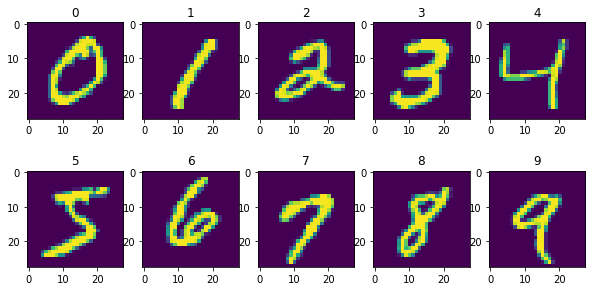

In [406]:
n_classes=10
inde= np.array([y_train==i for i in range(n_classes)])
f,ax = plt.subplots(2,5, figsize=(10,5))
ax=ax.flatten()
for i in range(n_classes):
    ax[i].imshow(x_train[np.argmax(inde[i])].reshape(28,28))
    ax[i].set_title(str(i))
plt.show()

In [361]:
#Build the network using keras
model= models.Sequential()
model.add(layers.Dense(512,activation='relu', input_shape=(28*28,)))
model.add(layers.Dense(10, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy, 
                  optimizer='rmsprop', 
                  metrics=['accuracy'])

In [362]:
#preprocess the images - normalizze the images so pixel values are between 0 and 1 instead of 0 and 255
x_train=x_train.reshape((60000,28*28))
x_train=x_train.astype('float32')/255
    
x_test=x_test.reshape((10000, 28*28))
    
x_test=x_test.astype('float32')/255

In [389]:
# convert the label to one hot vectors
from keras.utils import to_categorical
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test= keras.utils.to_categorical(y_test, num_classes)

In [364]:
model.fit(x_train, y_train, 
              batch_size=128, 
              epochs=5, shuffle=True, 
              )

Epoch 1/5
60000/60000 [==============================] - 3s 46us/step - loss: 0.2560 - acc: 0.9261
Epoch 2/5
60000/60000 [==============================] - 2s 37us/step - loss: 0.1028 - acc: 0.9690
Epoch 3/5
60000/60000 [==============================] - 2s 37us/step - loss: 0.0678 - acc: 0.9794
Epoch 4/5
60000/60000 [==============================] - 2s 37us/step - loss: 0.0496 - acc: 0.9849
Epoch 5/5
60000/60000 [==============================] - 2s 36us/step - loss: 0.0369 - acc: 0.9888


In [365]:
#model accuracy when trained on legitimate input
score, acc= model.evaluate(x_test, y_test, batch_size=128)
print("Test Accuracy: %.5f" % acc)

10000/10000 [==============================] - 0s 36us/step
Test Accuracy: 0.97930


In [366]:
model.save('cnn_mnist')

In [367]:
#use cleverhans library to generate adversarial examples
wrap= KerasModelWrapper(model)

In [374]:
x=tf.placeholder(tf.float32, shape=(None,784))
y=tf.placeholder(tf.float32, shape=(None,10))

In [372]:
fgsm= FastGradientMethod(wrap, sess=session)
fgsm

In [384]:
#FGSM- Gast Gradient Sign method - non targeted attack
fgsm_params= {'eps':0.08, 'clip_min':0.,'clip_max':1.}
adv_x = fgsm.generate(x, **fgsm_params)
adv_x=tf.stop_gradient(adv_x)
preds_adv=model(adv_x)

In [385]:
fetches=[preds_adv]
fetches.append(adv_x)
outputs=session.run(fetches=fetches, feed_dict={x:x_test})
preds_adv = outputs[0]
adv_examples=outputs[1]

In [408]:
adv_predicted=preds_adv.argmax(1)
adv_accuracy= np.mean(adv_predicted == y_test)
print("Adversaral accuracy: %.5f" % adv_accuracy)

Adversaral accuracy: 0.29790


In [379]:
import numpy as np

In [398]:
print(adv_predicted[1500])

1


In [399]:
print(y_test[1500])

7


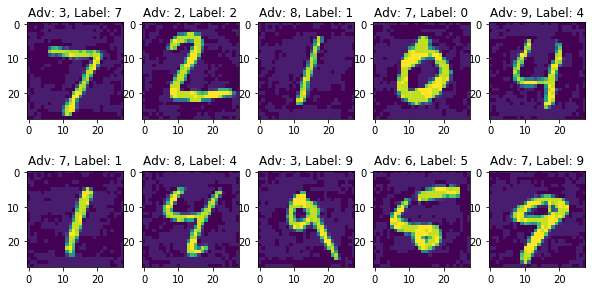

In [409]:
n_classes=10
f,ax = plt.subplots(2,5, figsize=(10,5))
ax=ax.flatten()
for i in range(n_classes):
    ax[i].imshow(adv_examples[i].reshape(28,28))
    ax[i].set_title("Adv: %d, Label: %d" % (adv_predicted[i], y_test[i]))
plt.show()